## Bayesian Optimisation Verification

In [8]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from itertools import product

# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [25]:
### Setup data for training and evaluation
# import data sheet (time:0~5000s) with temp 120, 140, 160, 180
address = 'data/degradation.xlsx'
y_normal = np.empty(shape=[0,1])
i = 3
list_temp = (120,140,160,180)
for temp in list_temp:
    df = pd.read_excel(address,sheet_name = 'normal data',usecols = [i],names = None,nrows = 5000)
    df = df.values.tolist()
    df = np.array(df)
    y_normal =  np.append(y_normal,df)
    i+=1

# for temp in list_temp:
#     df_temp = np.full((5000,1),temp)
#     df = pd.read_excel(address,sheet_name = 'normal data',usecols = [i],names = None,nrows = 5000)
#     df = df.values.tolist()
#     df = np.array(df).T 
#     df = df.reshape((5000,1))
#     df_normal = np.hstack([df,df_temp])
#     y_normal =  np.concatenate([y_normal,df_normal])
#     i+=1

In [30]:
X_ = np.arange(0,5000).astype(int)
x_normal = np.empty(shape=[0,2])
for temp in (120,140,160,180):
    df_temp = np.full((5000,1),temp)
    x_normal_partial = np.hstack([X_.reshape(5000,1),df_temp])
    x_normal =  np.concatenate([x_normal,x_normal_partial])

NUM_OF_DATA_POINTS = 800

Y = y_normal[np.arange(0,19999,int(20000/NUM_OF_DATA_POINTS)).astype(int)]

X = np.empty(shape=[0,2])
X_num = np.linspace(0,4999,num=int(NUM_OF_DATA_POINTS/4),dtype=int)
for temp in (120,140,160,180):
    df_temp = np.full((int(NUM_OF_DATA_POINTS/4),1),temp)
    X_partial = np.hstack([X_num.reshape(int(NUM_OF_DATA_POINTS/4),1),df_temp])
    X = np.concatenate([X, X_partial])

df_temp = np.full((5000,1),120)



In [31]:
# Kernel setting and prediction
kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp.fit(X, Y)
print("Learned kernel", gp.kernel_)

Learned kernel 0.385**2 * RBF(length_scale=[33.6, 68.1])


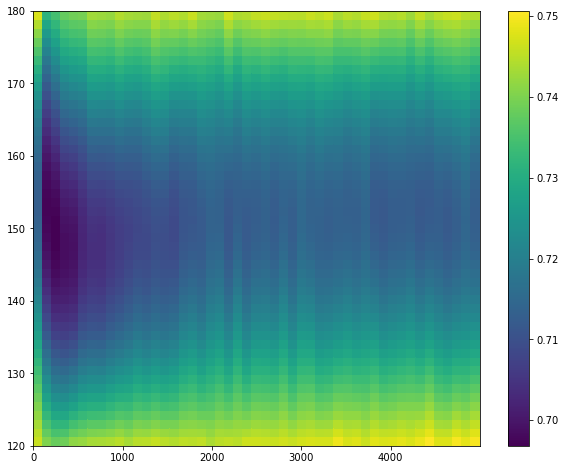

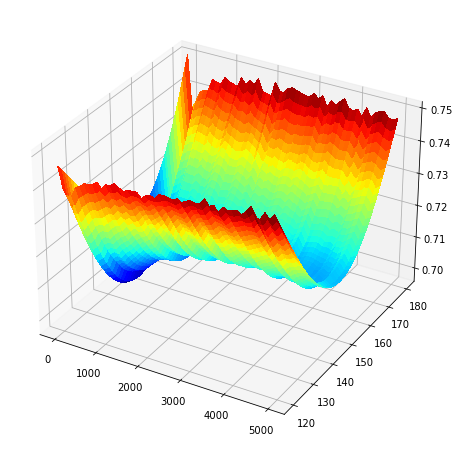

In [36]:
x1 = np.linspace(X[:,0].min(), X[:,0].max())
x2 = np.linspace(X[:,1].min(), X[:,1].max())
x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(X0p, X1p, Zp)
fig.colorbar(pcm, ax=ax)
plt.show()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')            
surf = ax.plot_surface(X0p, X1p, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
plt.show()